# Rice Yield Prediction: LightGBM with Optuna Tuning

## Overview
This notebook trains a **Gradient Boosting Machine (LightGBM)** to predict Rice yields. 

## Methodology
1.  **Feature Analysis:** Displaying used features.
2.  **Time-Series Split (Consistency Check):**
    * **Train (< 2016):** Model learning.
    * **Validation (2016 - 2020):** Hyperparameter tuning and early stopping.
    * **Test (>= 2020):** Final unseen evaluation.
3.  **Baseline:** Naive approach (Last Year's Yield).
4.  **Initial Model & Diagnostics:** Training a default LightGBM and plotting the **Learning Curve** to check for under/overfitting.
5.  **Optimization:** Using **Optuna** to find the best hyperparameters, visualized with parallel coordinates and importance plots.
6.  **Final Evaluation:** Comparing RMSE and R2 across all stages.

In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Loading

In [27]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v3.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4687


### 2. Feature Selection & Data Split
We display the features being used and split the data strictly by year to prevent leakage.

In [28]:
# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
# Example: If predicting Rice, we drop 'avg_yield_lettuce_1y', etc.

print(df.columns.tolist())

cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019) -> This covers 2014 to 2018
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
# Subtract 1 here to show the inclusive range (2014-2018)
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")


['year', 'area', 'avg_yield_maize_corn_1y', 'avg_yield_maize_corn_2y', 'avg_yield_maize_corn_3y', 'avg_yield_other_vegetables_fresh_nec_1y', 'avg_yield_other_vegetables_fresh_nec_2y', 'avg_yield_other_vegetables_fresh_nec_3y', 'avg_yield_potatoes_1y', 'avg_yield_potatoes_2y', 'avg_yield_potatoes_3y', 'avg_yield_rice_1y', 'avg_yield_rice_2y', 'avg_yield_rice_3y', 'avg_yield_sugar_cane_1y', 'avg_yield_sugar_cane_2y', 'avg_yield_sugar_cane_3y', 'avg_yield_wheat_1y', 'avg_yield_wheat_2y', 'avg_yield_wheat_3y', 'avg_yield_oil_palm_fruit_1y', 'avg_yield_oil_palm_fruit_2y', 'avg_yield_oil_palm_fruit_3y', 'avg_yield_barley_1y', 'avg_yield_barley_2y', 'avg_yield_barley_3y', 'avg_yield_soya_beans_1y', 'avg_yield_soya_beans_2y', 'avg_yield_soya_beans_3y', 'avg_yield_sugar_beet_1y', 'avg_yield_sugar_beet_2y', 'avg_yield_sugar_beet_3y', 'avg_yield_watermelons_1y', 'avg_yield_watermelons_2y', 'avg_yield_watermelons_3y', 'avg_yield_cucumbers_and_gherkins_1y', 'avg_yield_cucumbers_and_gherkins_2y', 'a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples   (<2016)     : 3774
Validation Samples (2016-2019): 458
Testing Samples    (>=2020)    : 455


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [29]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 527.28


### 4. Initial Model & Learning Curve Analysis
We train a model with default parameters and visualize the **Learning Curve** to ensure the model is converging and check for early signs of overfitting.

Training until validation scores don't improve for 50 rounds
[100]	Train's rmse: 375.33	Train's l2: 140873	Validation's rmse: 487.645	Validation's l2: 237798
Early stopping, best iteration is:
[77]	Train's rmse: 401.677	Train's l2: 161344	Validation's rmse: 483.638	Validation's l2: 233906


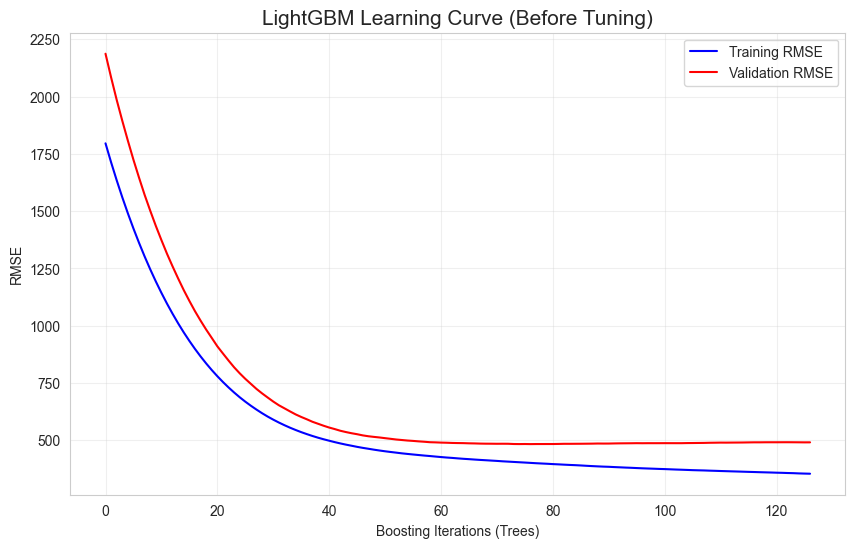

Initial Model Test RMSE: 491.24


In [30]:
# --- INITIAL MODEL TRAINING ---

# 1. Initialize LightGBM
model_init = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# 2. Dictionary to store training metrics for plotting
evals_result = {}

# 3. Train on TRAIN, Early Stop on VALIDATION
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_names=['Train', 'Validation'],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# --- PLOT LEARNING CURVE (RMSE over Iterations) ---
def plot_learning_curve(evals_result, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = evals_result['Train'][metric]
    val_metric = evals_result['Validation'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title('LightGBM Learning Curve (Before Tuning)', fontsize=15)
    plt.xlabel('Boosting Iterations (Trees)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(evals_result)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize hyperparameters to minimize RMSE on the Validation set.

In [31]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.6),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_LGBM')
study.optimize(objective, n_trials=30)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-08 03:08:11,958] A new study created in memory with name: Rice_Yield_LGBM
[I 2025-12-08 03:08:12,047] Trial 0 finished with value: 492.6587262384835 and parameters: {'learning_rate': 0.06947571350685504, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 66, 'subsample': 0.7573540157522046, 'colsample_bytree': 0.4781817213416183, 'reg_alpha': 0.0587071200232254, 'reg_lambda': 0.03347180296845216}. Best is trial 0 with value: 492.6587262384835.
[I 2025-12-08 03:08:12,083] Trial 1 finished with value: 484.18438347183076 and parameters: {'learning_rate': 0.08519403952563298, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 64, 'subsample': 0.6799853511546222, 'colsample_bytree': 0.35434795822098775, 'reg_alpha': 3.7284199760538342e-06, 'reg_lambda': 1.8307871259189193e-08}. Best is trial 1 with value: 484.18438347183076.
[I 2025-12-08 03:08:12,160] Trial 2 finished with value: 485.0599553647043 and parameters: {'learning_rate': 0.06931574904797522, 'num_leaves': 72, 


Best Parameters found:
{'learning_rate': 0.04069309599363411, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8904815943164822, 'colsample_bytree': 0.4181284998302704, 'reg_alpha': 0.00010370433872959768, 'reg_lambda': 0.00023531663198225346}


### 6. Optuna Visualization
Visualizing the tuning process to understand parameter importance and convergence.

In [32]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_Model"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
# fig.write_image(f'optuna_{name}_history.png') # Optional save
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_parallel_coordinate.png')
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
# fig.write_image(f'optuna_{name}_slice.png')
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    # fig.write_image(f'optuna_{name}_param_importance.png')
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Tuned Model Training
Retraining the model using the best parameters found on the full history (Train + Validation).

In [33]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMRegressor(**best_params)

# 3. Train on Full History
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	training's rmse: 368.428	training's l2: 135739	valid_1's rmse: 492.232	valid_1's l2: 242293


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=527.28, R2=0.9441
Initial Model:  RMSE=491.24, R2=0.9514
Tuned Model:    RMSE=492.23, R2=0.9513 (RMSE Improved 6.65%)


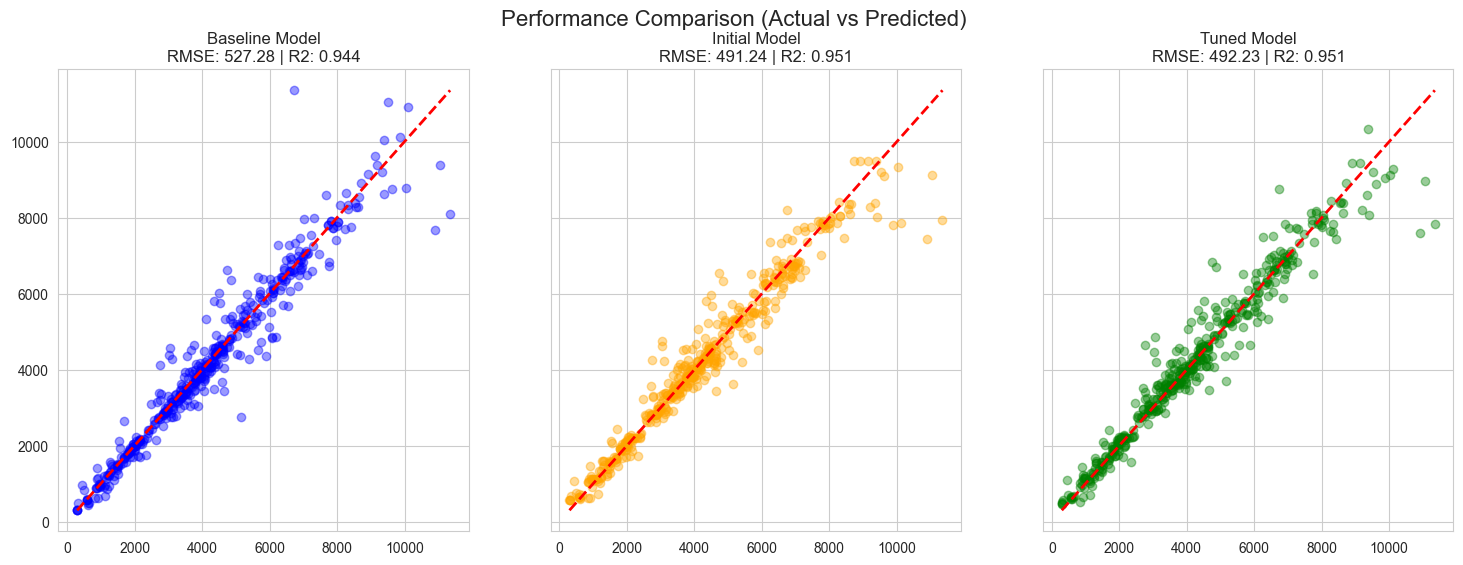

In [34]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle('Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance (Gain)
0   avg_yield_rice_2y       7.400997e+10
1   avg_yield_rice_1y       5.300730e+10
2   avg_yield_rice_3y       4.047648e+10
3     fertilizer_lag1       6.804805e+09
4            latitude       4.024697e+09
5        solar_annual       2.355555e+09
6            temp_cos       1.994940e+09
7         rain_annual       1.735388e+09
8           longitude       1.503366e+09
9         temp_annual       1.277249e+09
10          solar_sin       7.079155e+08
11               year       7.041636e+08
12    pesticides_lag1       6.154920e+08
13          solar_cos       4.579005e+08
14           temp_sin       4.254889e+08
15           rain_sin       3.195415e+08
16           rain_cos       3.011624e+08


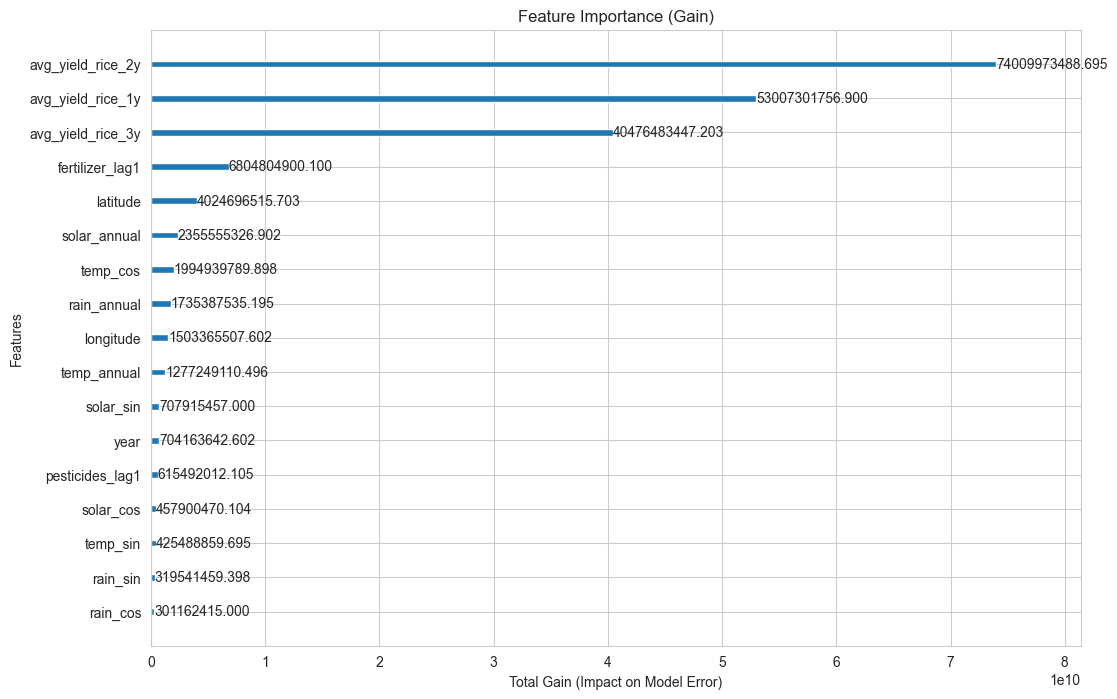

In [35]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances (using 'gain' for accuracy contribution)
importances = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.feature_name_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Gain)': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance (Gain)', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use LightGBM's built-in plotter
lgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    figsize=(12, 8), 
    title='Feature Importance (Gain)',
    xlabel='Total Gain (Impact on Model Error)'
)
plt.show()